# Measuring delay between excitation and inhibition on the same trial

## The cell is patched at -30mV, so we can analyze the onsets of both E and I in the same trial.

In [1]:
from Linearity import Neuron
import numpy as np
import scipy.stats as ss

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
n = Neuron.load('/home/sahil/Documents/Codes/bgstimPlasticity/data/august/current_try/161220/c2_EI/plots/c2_EI.pkl')

In [4]:
def findExcOnset(trace, inh_onset, step = 20, threshold= 0.5):
    #maxOnset = np.argmax(trace)
    maxOnset = inh_onset
    lmargin = maxOnset - step
    rmargin = maxOnset
    while lmargin > 0:
        d, pval= ss.ks_2samp(trace[lmargin:rmargin],trace[:3*step])
        if pval > threshold:
            return lmargin+step
        else:
            lmargin -=1
            rmargin -=1
            
            if lmargin < 3*step:
                #print("Reducing threshold")
                threshold/=1.25
                lmargin = maxOnset - step
                rmargin = maxOnset
            if threshold <0.01:
                return np.nan
    return np.nan

In [5]:
def findInhOnset(trace):
    maxOnset = np.argmax(trace)
    return np.argmin(trace[:maxOnset])
#     rightMargin = np.argmax(trace[exc_onset:]>trace[exc_onset])
#     if rightMargin:
#         return exc_onset + np.argmin(trace[exc_onset:exc_onset+rightMargin])
#     else:
#         return np.nan

<IPython.core.display.Javascript object>


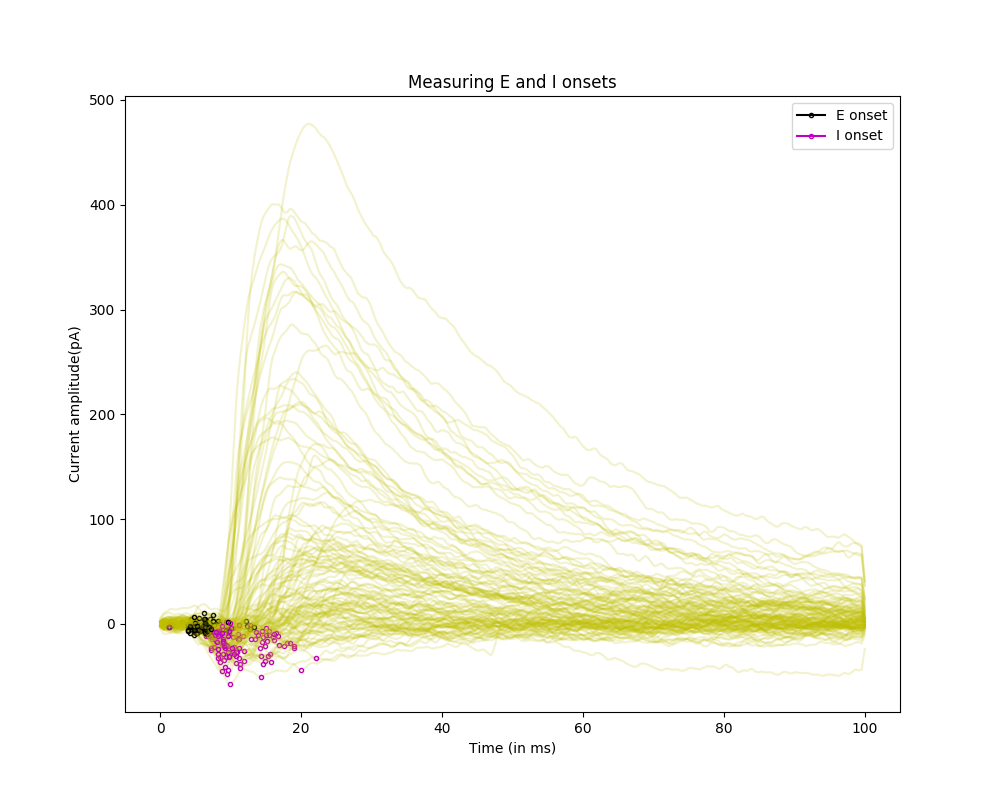

In [6]:
step_size = 20 # points
f, ax = plt.subplots(figsize=(10,8))
exc, inh, exc_onset, inh_onset = {}, {}, {}, {}
maxInh, delay = [], []
for exp in n:
    for sq in exp:
        color = ['blue','green']
        for trial in exp[sq].trial:
#             if 1 < trial < 3:
                #trace = exp[sq].trial[trial].interestWindow[:]
                exp[sq].trial[trial]._smoothen(1)
                trace = exp[sq].trial[trial].interestWindow*1e9
                #plt.plot(trace, 'c.')
                #plt.plot(trace1, 'k--')
                baseline = exp[sq].trial[trial].baselineWindow
                timeToPeak = exp[sq].trial[trial].feature[6]
                maxTrace = np.max(np.abs(trace))
                if timeToPeak:
                        if (exp[sq].type == 3):
                            #print (trial)
                            inh_onset = findInhOnset(trace)
                            if not np.isnan(inh_onset) and not exp[sq].trial[trial].noise_flag:
                                exc_onset = findExcOnset(trace, inh_onset)
                                if not np.isnan(exc_onset):
                                    maxInh.append(np.max(trace))
                                    delay.append((inh_onset - exc_onset)/20.)
                                    plt.plot(np.linspace(0,len(trace)/20., len(trace)), trace, alpha=0.2, color='y')
                                    plt.plot([exc_onset/20.], [trace[exc_onset]], marker='o', color='k', markersize=3, mfc='none', label='E onset')
                                    plt.plot([inh_onset/20.], [trace[inh_onset]], marker='o', color='m', markersize=3, mfc='none', label='I onset')
plt.title("Measuring E and I onsets")
plt.xlabel("Time (in ms)")
plt.ylabel("Current amplitude(pA)")

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)

<IPython.core.display.Javascript object>


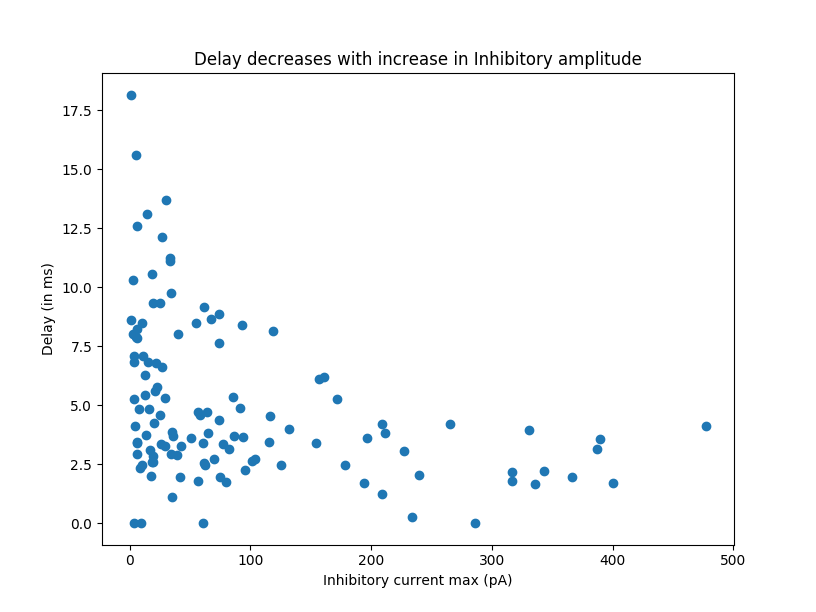

In [7]:
plt.scatter(maxInh, delay)
plt.title("Delay decreases with increase in Inhibitory amplitude")
plt.xlabel("Inhibitory current max (pA)")
plt.ylabel("Delay (in ms)")

<IPython.core.display.Javascript object>


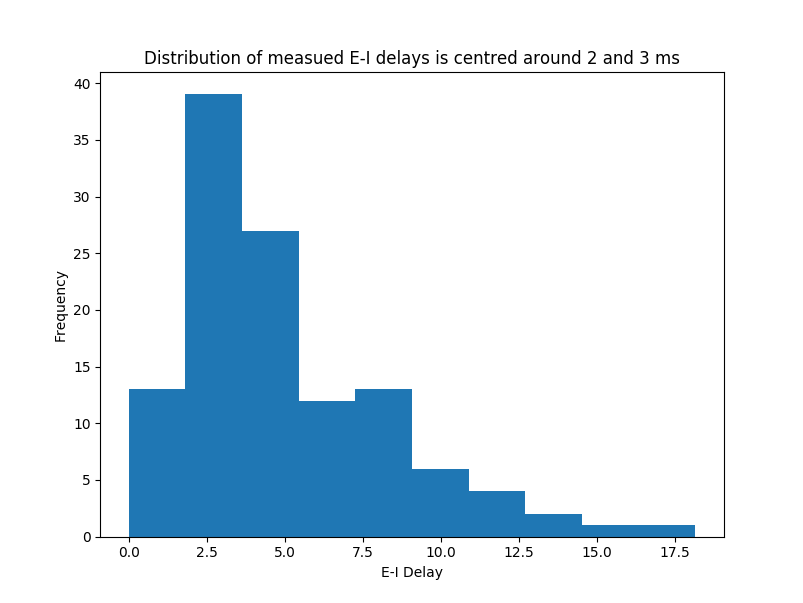

In [8]:
plt.hist(delay)
plt.xlabel("E-I Delay")
plt.ylabel("Frequency")
plt.title("Distribution of measued E-I delays is centred around 2 and 3 ms")